# Text Classification - IMDB

# Imports 

In [1]:
import numpy as np
import pandas as pd

#for nlp
import nltk
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

#text vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

#metrics
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc

#import method releated to evaluation
from sklearn import model_selection
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, StratifiedShuffleSplit, ShuffleSplit, cross_val_score, GridSearchCV

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#for graphs
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Global vairiables for script

cross_validation_iterations = 30


# Exploring the Dataset

In [3]:
filename = 'SMSSpamData.csv'
SPAM_dataframe = pd.read_csv(filename, encoding='utf-8')

In [4]:
SPAM_dataframe.head()

,class,sms_msg
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Converting Class Index to int

In [5]:
class_mapping = {label:idx for idx,label in enumerate(np.unique(SPAM_dataframe['class']))}

print(class_mapping)
class_labels = [x for x in class_mapping] # store the class labels for later

{'ham': 0, 'spam': 1}


In [6]:
#use the mapping dictionary to transform the class labels into integers

SPAM_dataframe["class"] = SPAM_dataframe["class"].map(class_mapping)


In [7]:
SPAM_dataframe.head()

,class,sms_msg
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


# Cleaning up the Data

In [8]:
SPAM_dataframe.loc[42, 'sms_msg']#[-50:]

'07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow'

In [9]:
#import regular expressions to clean up the text
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text) # remove all html markup
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # findall the emoticons
    
    # remove the non-word chars '[\W]+'
    # append the emoticons to end 
    #convert all to lowercase
    # remove nose char for consistency
    text = (re.sub('[\W]+', ' ', text.lower()) +
            ' '.join(emoticons).replace('-', '')) 
    return text

In [10]:
preprocessor(SPAM_dataframe.loc[42, 'sms_msg'])#[-50:]

'07732584351 rodger burns msg we tried to call you re your reply to our sms for a free nokia mobile free camcorder please call now 08000930705 for delivery tomorrow'

In [11]:
# apply the preprocessor to the entire dataframe (i.e. column review)
SPAM_dataframe['sms_msg'] = SPAM_dataframe['sms_msg'].apply(preprocessor)

# Tokenise, Stemmer & Stop

In [12]:
from nltk.corpus import stopwords 

nltk.download('stopwords')


stop = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def tokenizer(text):
    text = str(text)
    return text.split()

def tokenizer_stemmer(text):
    return [stemmer.stem(word) for word in tokenizer(text)]#text.split()]


def stop_removal(text):
       return [w for w in text if not w in stop]
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
SPAM_dataframe.loc[42, 'sms_msg']

'07732584351 rodger burns msg we tried to call you re your reply to our sms for a free nokia mobile free camcorder please call now 08000930705 for delivery tomorrow'

In [14]:
# SPAM_dataframe_subset = SPAM_dataframe.sample(n=1000)
SPAM_dataframe_subset = SPAM_dataframe

# Training for Sentiment Classification

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
     SPAM_dataframe_subset.iloc[:,1], SPAM_dataframe_subset.iloc[:,0], test_size=0.20, random_state=42)

In [16]:
param_grid0 = [{'vect__ngram_range': [(1, 1)], #can also extract 2-grams of words in addition to the 1-grams (individual words)
               'vect__stop_words': [stop, None], # use the stop dictionary of stopwords or not
               'vect__tokenizer': [tokenizer_stemmer]}, # use a tokeniser and the stemmer 
               ]

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

results_list = []

names = []

raw_names = []

cv_results = []

predictions = []

best_settings = []


for func in [LogisticRegression(),
                   MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
                   SVC(kernel='rbf', gamma=0.7, C=1.0)]:
    results = {}
    
    stop_results = []
    none_results = []
    
    print("Testing: " + func.__class__.__name__)
    
    mnb_tfidf = Pipeline([('vect', tfidf),
                     ('clf',  func)])
                   
    gs_mnb_tfidf = GridSearchCV(mnb_tfidf, param_grid0,
                               scoring='accuracy',
                               cv=cross_validation_iterations,
                               verbose=1,
                               n_jobs=-1)
    
    gs_mnb_tfidf.fit(X_train, y_train)
    
         
    clf = gs_mnb_tfidf.best_estimator_
    
    print('Test Accuracy: %.3f' % (clf.score(X_test, y_test) * 100))

    print('CV Accuracy: %.3f' % (gs_mnb_tfidf.best_score_ * 100))
    
    results['cv_acc'] = gs_mnb_tfidf.best_score_* 100
    
    results['accuracy'] = clf.score(X_test, y_test) * 100
    
    results['name'] = func.__class__.__name__ 
    
    results_list.append(results)
    
    temp_split = []
    
    for split in range (0, gs_mnb_tfidf.n_splits_):
        
        print("CV split " + str(split + 1) + " results:")
        
        print(gs_mnb_tfidf.cv_results_['split'+ str(split) +'_test_score'])
        
        stop_results.append(gs_mnb_tfidf.cv_results_['split'+ str(split) +'_test_score'][0])
        none_results.append(gs_mnb_tfidf.cv_results_['split'+ str(split) +'_test_score'][1])
        
        
    predictions.append(clf.predict(X_test))
    best_settings.append(clf.get_params(GridSearchCV)['vect__stop_words']  )
        
    raw_names.append(func.__class__.__name__)
    
    names.append(func.__class__.__name__ + " StopWords")
    cv_results.append(stop_results)

    names.append(func.__class__.__name__ + " None")
    cv_results.append(none_results)
    
    

Testing: LogisticRegression
Fitting 30 folds for each of 2 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   23.8s finished


Test Accuracy: 97.758
CV Accuracy: 97.668
CV split 1 results:
[0.97333333 0.97333333]
CV split 2 results:
[0.95333333 0.96666667]
CV split 3 results:
[0.96666667 0.97333333]
CV split 4 results:
[0.97986577 0.98657718]
CV split 5 results:
[0.97986577 0.97315436]
CV split 6 results:
[0.97986577 0.98657718]
CV split 7 results:
[0.96644295 0.97315436]
CV split 8 results:
[0.98657718 0.98657718]
CV split 9 results:
[0.95973154 0.97986577]
CV split 10 results:
[0.99328859 0.99328859]
CV split 11 results:
[0.97986577 0.99328859]
CV split 12 results:
[0.97315436 0.97986577]
CV split 13 results:
[0.97986577 0.97986577]
CV split 14 results:
[0.95973154 0.97315436]
CV split 15 results:
[0.99328859 1.        ]
CV split 16 results:
[0.95973154 0.95302013]
CV split 17 results:
[0.97297297 0.99324324]
CV split 18 results:
[0.95945946 0.95945946]
CV split 19 results:
[0.93243243 0.93918919]
CV split 20 results:
[0.97972973 0.97972973]
CV split 21 results:
[0.95945946 0.96621622]
CV split 22 results:
[

[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   27.7s finished


Test Accuracy: 96.951
CV Accuracy: 96.614
CV split 1 results:
[0.98 0.98]
CV split 2 results:
[0.95333333 0.95333333]
CV split 3 results:
[0.96666667 0.95333333]
CV split 4 results:
[0.97986577 0.97986577]
CV split 5 results:
[0.96644295 0.96644295]
CV split 6 results:
[0.96644295 0.95973154]
CV split 7 results:
[0.95973154 0.94630872]
CV split 8 results:
[0.97315436 0.96644295]
CV split 9 results:
[0.97315436 0.96644295]
CV split 10 results:
[0.95302013 0.94630872]
CV split 11 results:
[0.97986577 0.97315436]
CV split 12 results:
[0.97986577 0.97986577]
CV split 13 results:
[0.95973154 0.94630872]
CV split 14 results:
[0.95302013 0.93959732]
CV split 15 results:
[0.97986577 0.97986577]
CV split 16 results:
[0.95302013 0.94630872]
CV split 17 results:
[0.99324324 0.97972973]
CV split 18 results:
[0.96621622 0.96621622]
CV split 19 results:
[0.93243243 0.93243243]
CV split 20 results:
[0.95945946 0.9527027 ]
CV split 21 results:
[0.97297297 0.97297297]
CV split 22 results:
[0.97972973 0

[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   44.6s finished


Test Accuracy: 98.655
CV Accuracy: 98.744
CV split 1 results:
[0.98666667 0.98666667]
CV split 2 results:
[0.98666667 0.98666667]
CV split 3 results:
[0.99333333 0.99333333]
CV split 4 results:
[0.98657718 1.        ]
CV split 5 results:
[0.97986577 0.98657718]
CV split 6 results:
[0.99328859 0.99328859]
CV split 7 results:
[0.98657718 0.98657718]
CV split 8 results:
[0.99328859 1.        ]
CV split 9 results:
[0.98657718 0.99328859]
CV split 10 results:
[1.         0.99328859]
CV split 11 results:
[0.99328859 0.99328859]
CV split 12 results:
[1. 1.]
CV split 13 results:
[0.98657718 0.98657718]
CV split 14 results:
[0.97315436 0.97986577]
CV split 15 results:
[1. 1.]
CV split 16 results:
[0.96644295 0.97315436]
CV split 17 results:
[1. 1.]
CV split 18 results:
[0.97297297 0.97297297]
CV split 19 results:
[0.93918919 0.94594595]
CV split 20 results:
[0.99324324 0.99324324]
CV split 21 results:
[0.97972973 0.98648649]
CV split 22 results:
[0.99324324 1.        ]
CV split 23 results:
[1. 

In [18]:
df_results = pd.DataFrame(results_list) 
df_results

,accuracy,cv_acc,name
0,97.757848,97.667638,LogisticRegression
1,96.950673,96.613590,MultinomialNB
2,98.654709,98.744113,SVC


In [19]:
# gs_mnb_tfidf.n_splits_

In [20]:
# stop_results

In [21]:
cv_results

[[0.9733333333333334,
  0.9533333333333334,
  0.9666666666666667,
  0.9798657718120806,
  0.9798657718120806,
  0.9798657718120806,
  0.9664429530201343,
  0.9865771812080537,
  0.959731543624161,
  0.9932885906040269,
  0.9798657718120806,
  0.9731543624161074,
  0.9798657718120806,
  0.959731543624161,
  0.9932885906040269,
  0.959731543624161,
  0.972972972972973,
  0.9594594594594594,
  0.9324324324324325,
  0.9797297297297297,
  0.9594594594594594,
  0.9864864864864865,
  0.9797297297297297,
  0.9662162162162162,
  0.9797297297297297,
  0.972972972972973,
  0.972972972972973,
  0.9594594594594594,
  0.9864864864864865,
  0.9594594594594594],
 [0.9733333333333334,
  0.9666666666666667,
  0.9733333333333334,
  0.9865771812080537,
  0.9731543624161074,
  0.9865771812080537,
  0.9731543624161074,
  0.9865771812080537,
  0.9798657718120806,
  0.9932885906040269,
  0.9932885906040269,
  0.9798657718120806,
  0.9798657718120806,
  0.9731543624161074,
  1.0,
  0.9530201342281879,
  0.9932

In [22]:
for method in range(0, len(cv_results)):
    print(names[method])
    print(cv_results[method])
    print("---")

LogisticRegression StopWords
[0.9733333333333334, 0.9533333333333334, 0.9666666666666667, 0.9798657718120806, 0.9798657718120806, 0.9798657718120806, 0.9664429530201343, 0.9865771812080537, 0.959731543624161, 0.9932885906040269, 0.9798657718120806, 0.9731543624161074, 0.9798657718120806, 0.959731543624161, 0.9932885906040269, 0.959731543624161, 0.972972972972973, 0.9594594594594594, 0.9324324324324325, 0.9797297297297297, 0.9594594594594594, 0.9864864864864865, 0.9797297297297297, 0.9662162162162162, 0.9797297297297297, 0.972972972972973, 0.972972972972973, 0.9594594594594594, 0.9864864864864865, 0.9594594594594594]
---
LogisticRegression None
[0.9733333333333334, 0.9666666666666667, 0.9733333333333334, 0.9865771812080537, 0.9731543624161074, 0.9865771812080537, 0.9731543624161074, 0.9865771812080537, 0.9798657718120806, 0.9932885906040269, 0.9932885906040269, 0.9798657718120806, 0.9798657718120806, 0.9731543624161074, 1.0, 0.9530201342281879, 0.9932432432432432, 0.9594594594594594, 0.

In [23]:
gs_mnb_tfidf.cv_results_

{'mean_fit_time': array([4.11220376, 3.75023812]),
 'std_fit_time': array([0.52905331, 0.40366287]),
 'mean_score_time': array([0.11968474, 0.1148126 ]),
 'std_score_time': array([0.01056807, 0.01232242]),
 'param_vect__ngram_range': masked_array(data=[(1, 1), (1, 1)],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_vect__stop_words': masked_array(data=[{'my', 'yourself', 't', 'had', 'should', 'on', 'hadn', 'ourselves', "it's", 'needn', 'while', 'his', 'not', 'shouldn', 'too', "that'll", 'has', 'doesn', 'hasn', 'before', 'they', 'o', "isn't", "weren't", 'now', 'your', 'whom', 'with', 'most', 'an', 'mustn', 'in', "wasn't", 'each', 'through', "needn't", 'does', 're', "couldn't", 'up', 'didn', 'you', 'between', 'them', 'by', 'any', 'for', 'did', 'can', 'that', 'the', 'about', 'further', 'd', 'we', 'at', 'is', 'there', 'aren', 'these', "she's", "aren't", 'be', 'been', "you're", 'he', 'herself', 'here', 'only', 'a', 'having', 'because', 'such',

In [24]:
# fig = plt.figure()
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(cv_results)
# ax.set_xticklabels(names)
# plt.show()

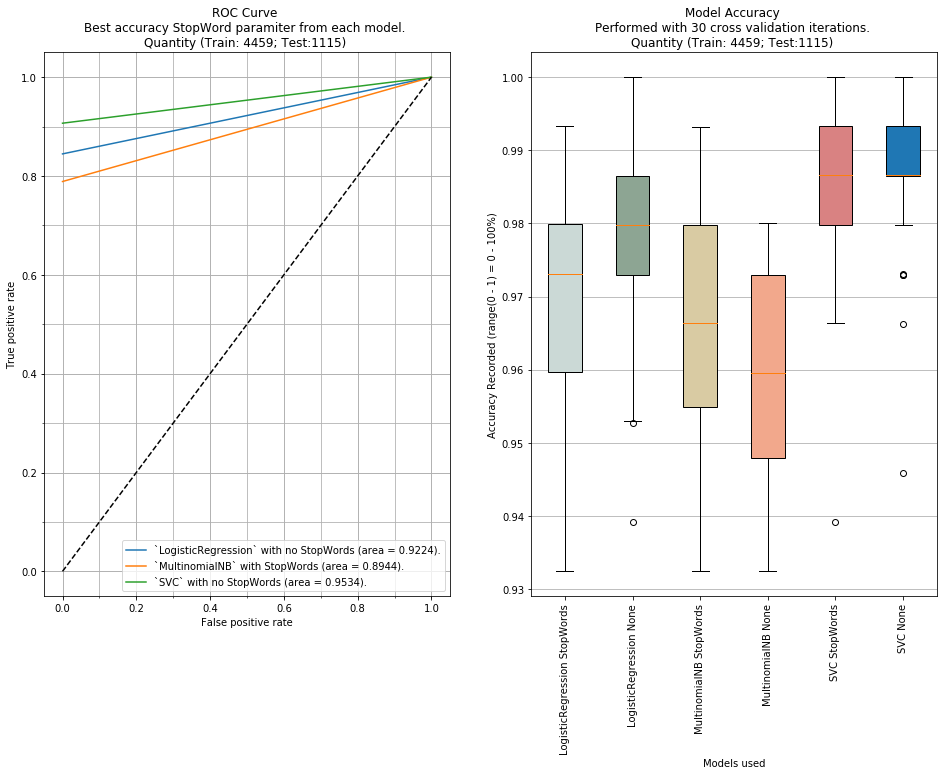

In [25]:
from matplotlib.ticker import MultipleLocator

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))

for predict in range(0, len(predictions)):
    fpr, tpr, threshold = roc_curve(y_test, predictions[predict]) 

# This is the AUC
    the_auc = auc(fpr, tpr)
# This is the ROC curve
    if best_settings[predict]:
        plot_label = "`" + raw_names[predict] + "` with StopWords (area = "+str(round(the_auc, 4))+")."
    else:
        plot_label = "`" + raw_names[predict] + "` with no StopWords (area = "+str(round(the_auc, 4))+")."
    axes[0].plot(fpr,tpr, label=plot_label)

axes[0].plot([0, 1], [0, 1], 'k--') # diagonal    

axes[0].set_title('ROC Curve \n'+
                  'Best accuracy StopWord paramiter from each model. \n' +
                 'Quantity (Train: ' + str(X_train.count()) + '; Test:' + str(X_test.count())+') ')
axes[0].set_xlabel('False positive rate')
axes[0].set_ylabel('True positive rate')
axes[0].legend(loc='best')
axes[0].xaxis.grid(True)

spacing = 0.1 # This can be your user specified spacing. 
minorLocator = MultipleLocator(spacing)

axes[0].yaxis.set_minor_locator(minorLocator)
axes[0].xaxis.set_minor_locator(minorLocator)
axes[0].grid(which = 'minor')


# box plot

bplot2 = axes[1].boxplot(cv_results,
                         vert=True,  # vertical box alignment
                         patch_artist=True,  # fill with color
                         labels=names
                         )  # will be used to label x-ticks
axes[1].set_title('Model Accuracy \n'+ 
                  'Performed with ' + str(cross_validation_iterations) +' cross validation iterations. \n' + 
                  'Quantity (Train: ' + str(X_train.count()) + '; Test:' + str(X_test.count())+') ')

axes[1].set_xlabel('Models used')
axes[1].set_ylabel('Accuracy Recorded (range(0 - 1) = 0 - 100%)')

# fill with colors
colors = ['#CBD9D6', '#8DA593', '#D9CBA3', '#F2A88C', '#D98282']
for patch, color in zip(bplot2['boxes'], colors):
    patch.set_facecolor(color)

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)

    
    
plt.xticks(rotation=90)
plt.show()